In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pandas as pd
import time
from skimage import exposure

import keras
from keras import optimizers

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, Cropping2D
from keras.models import Sequential, Model
import tensorflow as tf
from keras.models import load_model
from itertools import zip_longest

Using TensorFlow backend.


In [2]:
PREPRO_FOLDER = '/media/datadrive1/kaggle-preprocs/'
MASK_FOLDER = '/media/datadrive1/kaggle-preprocs/mask_2D_50'
ENCODED_FOLDER = '/media/datadrive1/kaggle-preprocs/mask_2D_50/encoded/'

minHU = -1000
maxHU = 400

BLOCK_SIZE = 64
BATCH_SIZE = 10

In [3]:
lungs_info = pd.read_csv(os.path.join(PREPRO_FOLDER, 's1_metadata_with_label.csv'), index_col=0)
lungs_info.sort_values('cancer', ascending=False, inplace=True)

In [4]:
def read_mask(patient_info):
    patient_id = patient_info[0]
    mask_file = np.fromfile(os.path.join(MASK_FOLDER, patient_id+'_mask.bin'), np.int16).reshape((-1, BLOCK_SIZE, BLOCK_SIZE))
    mask_file = mask_file[::10]
    return mask_file

In [8]:
from multiprocessing.pool import ThreadPool
from collections import OrderedDict

#parallel threads
size=100

if not os.path.exists(MASK_FOLDER):
    os.makedirs(MASK_FOLDER)

with ThreadPool(size) as p:
    all_masks = p.map(read_mask, lungs_info.itertuples())
    patient_data = OrderedDict(zip(list(lungs_info.index), all_masks))
    all_masks = np.concatenate(all_masks)

In [12]:
all_masks.shape

(101370, 128, 128)

In [9]:
# input image dimensions
img_rows, img_cols, img_chns = BLOCK_SIZE, BLOCK_SIZE, 1
# number of convolutional filters to use
NB_FILTERS = 16
# convolution kernel size
KERNEL_SIZE = (3, 3)

original_img_size = (img_rows, img_cols, img_chns)

LATENT_DIM = 128
INTERMEDIATE_DIM = 256
NB_EPOCHS = 100


input_layer = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns, kernel_size=(2, 2), padding='same', activation='relu')(input_layer)
conv_2 = Conv2D(NB_FILTERS, kernel_size=(2, 2),
                       padding='same', activation='relu',
                       strides=(2, 2))(conv_1)
conv_3 = Conv2D(NB_FILTERS, KERNEL_SIZE,
                       padding='same', activation='relu',
                       strides=(1, 1))(conv_2)
conv_4 = Conv2D(NB_FILTERS, KERNEL_SIZE,
                       padding='same', activation='relu',
                       strides=(1, 1))(conv_3)
flat = Reshape((-1,))(conv_4)
hidden = Dense(INTERMEDIATE_DIM, activation='relu')(flat)

z = Dense(LATENT_DIM)(hidden)

decoder_hid = Dense(INTERMEDIATE_DIM, activation='relu')
decoder_upsample = Dense(NB_FILTERS * img_rows//2 * img_rows//2, activation='relu')

decoder_reshape = Reshape((img_rows//2, img_rows//2, NB_FILTERS))
decoder_deconv_1 = Conv2DTranspose(NB_FILTERS, KERNEL_SIZE,
                                   padding='same',
                                   strides=(1, 1),
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(NB_FILTERS, KERNEL_SIZE,
                                   padding='same',
                                   strides=(1, 1),
                                   activation='relu')

decoder_deconv_3_upsamp = Conv2DTranspose(NB_FILTERS, kernel_size=(2, 2),
                                          padding='valid',
                                          strides=(2, 2),
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns, kernel_size=(1, 1),
                                    padding='valid',
                                    activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

ae = Model(input_layer, x_decoded_mean_squash)
ae.compile(optimizer='rmsprop', loss='mean_squared_error')
ae.summary()

encoder = Model(inputs=ae.input,outputs=z)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 1)       5         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 16)        80        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
reshape_3 (Reshape)          (None, 65536)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               16777472  
__________

In [10]:
def batch_generator(data, batch_size=32):
    samples = len(data)
    while True:
        idxes = np.arange(samples)
        np.random.shuffle(idxes)
        batch = np.copy(data[idxes[:batch_size]])
        batch = (batch - minHU) / (maxHU - minHU)
        for i,samp in enumerate(batch):
            batch[i] = exposure.equalize_adapthist(samp)
        batch = np.expand_dims(batch, 3)
        yield batch, batch

In [11]:
ae.load_weights(os.path.join(MASK_FOLDER, 'kaggle_128.h5'))

In [ ]:
ae.fit_generator(batch_generator(all_masks, BATCH_SIZE),
                 steps_per_epoch = 2000, 
#                  steps_per_epoch = len(all_masks)//BATCH_SIZE, 
                 epochs = 100,
                 verbose = 1)
ae.save(os.path.join(MASK_FOLDER, 'kaggle_128.h5'))

Epoch 1/100


/home/marco/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


2000/2000 [==============================] - 240s - loss: 0.0123      

In [38]:
prova = next(batch_generator(all_masks, BATCH_SIZE))
provaae = ae.predict(prova[0])

/home/marco/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


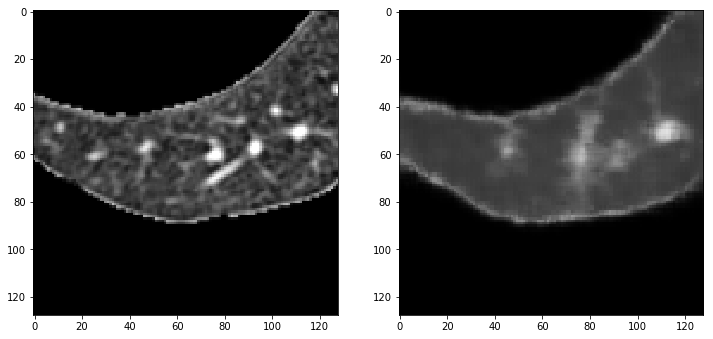

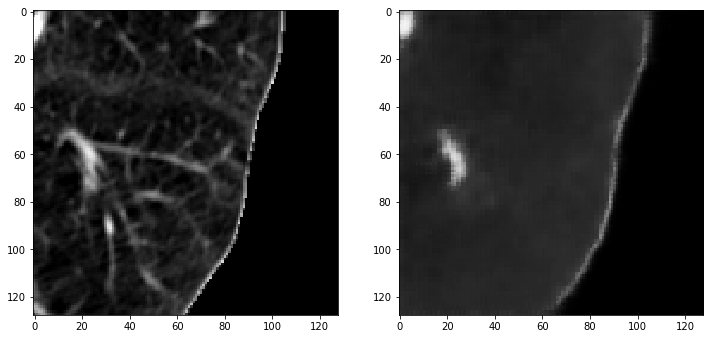

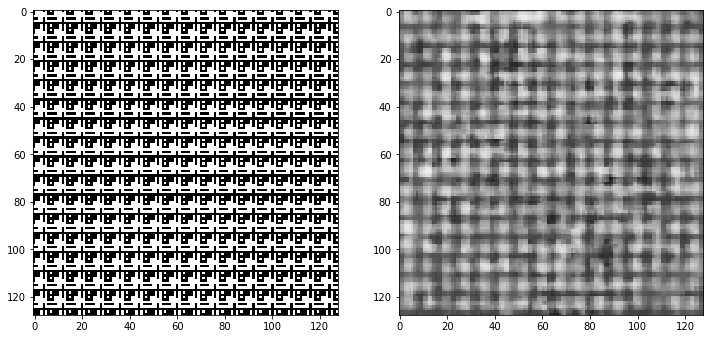

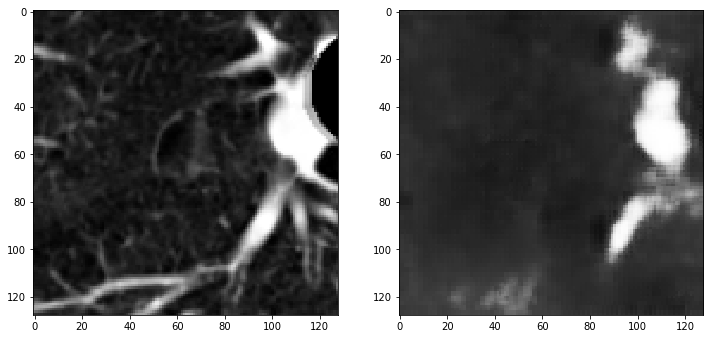

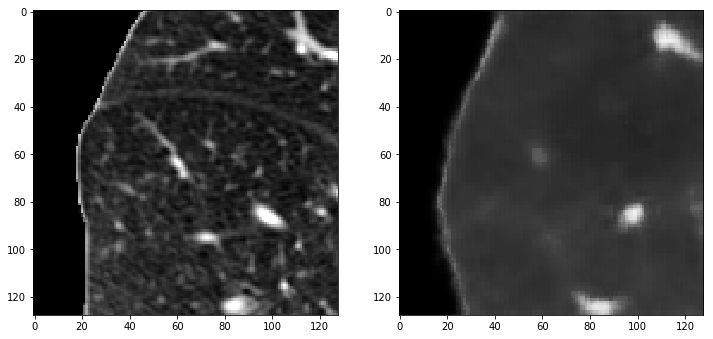

In [39]:
for i in range(5):
    plt.figure(figsize=(12,12))
    plt.subplot(121)
    plt.imshow(prova[0][i,:,:,0], cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.subplot(122)
#    plt.imshow(batch[i][:,:,0], cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.imshow(provaae[i,:,:,0], cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.show()

In [ ]:
if not os.path.exists(ENCODED_FOLDER):
    os.makedirs(ENCODED_FOLDER)

for patient_id in lungs_info.index:
    blocks_of_patient = patient_data[patient_id]
    processed_data = next(batch_generator(blocks_of_patient, len(blocks_of_patient)))[0]
    encoded = encoder.predict(processed_data)
    np.savetxt(os.path.join(ENCODED_FOLDER, patient_id+'_encoded.dat'), encoded, fmt='%12.8f')

/home/marco/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [13]:
prova = next(batch_generator(all_masks, BATCH_SIZE))

/home/marco/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [17]:
ae.load_weights('kaggle_128.h5')